# Analytic Solution - Poiseuille Flow

The example of 2D flow in a channel will be used to verify the FEniCSx solver with the analytic solution. More details can be found in *PoiseuilleFlow_walkthrough.ipynb* and at https://jsdokken.com/dolfinx-tutorial/chapter2/ns_code1.html.

## Problem Defninition

Fuid flow through a channel is known as Poiseuille flow, shown in the figure. In this case, the horizontal flow is driven by a pressure difference across the channel (left to right). The volocity profile of the flow is expected to be parabolic, with the maximum velocity at the center of the channel.

<img src="channelFlow.png" align="center">

$p_{inlet} = 8$  
$p_{outlet} = 0$  
$u_{walls} = 0$  
$ \rho = \mu = 1$  
$ f = 0$ (other body forces/sources)


## Analytic Solution

For this problem, the pressure and velocity along the x-axis can be found by

$$p(x) = 8(1-x)$$  
$$ u_x = 4y(1-y) $$

## Solution

First, import necessary packages and define the mesh, boundary conditions, constants, and function space. 

In [5]:
# **** IMPORT *** #

from mpi4py import MPI  # for parallel
from petsc4py import PETSc # matrix solver library
import numpy as np # for array manipulation
import pyvista # visualization
import matplotlib.pyplot as plt

from dolfinx.fem import Constant, Function, functionspace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical # define constants and functions, boundary conditions, 
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc # assemble matrix equations, apply and enforce BC
from dolfinx.io import VTXWriter # write to VTX
from dolfinx.mesh import create_unit_square # create square mesh
from dolfinx.plot import vtk_mesh # plot VTK mesh
from basix.ufl import element # make elements
from ufl import (FacetNormal, Identity, TestFunction, TrialFunction, # face normal vector, identity matrix, test and trial functions
                 div, dot, ds, dx, inner, lhs, nabla_grad, rhs, sym) # descirbe the variational form symbolically. math terms


# *** MESH *** #

mesh = create_unit_square(MPI.COMM_WORLD, 10, 10) # create 10x10 element square
t = 0 # initial time
T = 10 # total simulation time
num_steps = 500 # number of timesteps
dt = T / num_steps # calculate timestep 


# *** FUNCTION SPACE *** #

# Taylor Hood elements
v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, )) # define piecewise quadratic elements, vector should have same dimension as the mesh
s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1) # define piecewise linear elements
V = functionspace(mesh, v_cg2) # velocity function space
Q = functionspace(mesh, s_cg1) # pressure function space

# *** TRIAL FUNCTIONS *** #

u = TrialFunction(V) # trial functions for velocity
v = TestFunction(V) # admissable variations of V (velocity)
p = TrialFunction(Q) # trial functions for pressure
q = TestFunction(Q) # admissable variations of Q (pressure)


# *** DEFINE BOUNDARY CONDITIONS *** #

# 1. WALLS - top and bottom, no slip BC
# work with V function space because we are setting velocity BC

def walls(x): # define where the walls are
    return np.logical_or(np.isclose(x[1], 0), np.isclose(x[1], 1))

wall_dofs = locate_dofs_geometrical(V, walls) # find the dofs on the walls
u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType) # define no slip zero velocity, velocity vector has same dimension as the mesh
bc_noslip = dirichletbc(u_noslip, wall_dofs, V) # apply no slip to walls dof, array of scalars, V = 0

# 2. INLET - high pressure driven frow from the left
# work with Q function space because we are setting pressure BC

def inflow(x): # define where the inlet is
    return np.isclose(x[0], 0)

inflow_dofs = locate_dofs_geometrical(Q, inflow) # find dofs at the inlet
bc_inflow = dirichletbc(PETSc.ScalarType(8), inflow_dofs, Q) # assign Dirichlet BC at inlet dofs, p = 8, scalar

# 3. OUTLET - low pressure on the right to drive flow
# work with Q function space because we are setting pressure BC

def outflow(x): # define where the outlet is
    return np.isclose(x[0], 1)

outflow_dofs = locate_dofs_geometrical(Q, outflow) # find dofs at the outlet
bc_outflow = dirichletbc(PETSc.ScalarType(0), outflow_dofs, Q) # assign Dirichlet BC at outlet dofs, p = 0, scalar
bcu = [bc_noslip]
bcp = [bc_inflow, bc_outflow]


# *** DEFINE CONSTANTS/VARIABLES *** #

n = FacetNormal(mesh) # normal vector
# define parameters as constants (dolphinx function)
f = Constant(mesh, PETSc.ScalarType((0, 0))) # additional body forces (none here)
k = Constant(mesh, PETSc.ScalarType(dt)) # timestep
mu = Constant(mesh, PETSc.ScalarType(1)) # viscosity
rho = Constant(mesh, PETSc.ScalarType(1)) # density

# Define strain-rate tensor
def epsilon(u):
    return sym(nabla_grad(u))

# Define stress tensor
def sigma(u, p):
    return 2 * mu * epsilon(u) - p * Identity(len(u))

Nest, set up the variational forms (define the equations to be solved) and choose settings for the solver.

In [6]:
# *** FIRST VARIATIONAL FORM *** #

# first variational problem
u_n = Function(V)  # velocity form last time
u_n.name = "u_n" # name the variable
U = 0.5 * (u_n + u) # velocity predictor (u^{n+1/2})

# Define the variational problem for the first step
# <trial function, test function>

p_n = Function(Q) # pressure from last step 
p_n.name = "p_n" # name variable
F1 = rho * dot((u - u_n) / k, v) * dx # first term eq. 39
F1 += rho * dot(dot(u_n, nabla_grad(u_n)), v) * dx # second term eq.39
F1 += inner(sigma(U, p_n), epsilon(v)) * dx # third term eq. 39
F1 += dot(p_n * n, v) * ds - dot(mu * nabla_grad(U) * n, v) * ds # fourth term eq 39
F1 -= dot(f, v) * dx # fifth term eq. 39
a1 = form(lhs(F1)) # a1 = LHS of eq. 39
L1 = form(rhs(F1)) # L1 = rhs of eq. 39

# assemble matrix equation : A1*U = b1
A1 = assemble_matrix(a1, bcs=bcu) # assemble matrix for lhs of 39, note boundary conditions
A1.assemble() # assemble step
b1 = create_vector(L1) # rhs of equation to be solved

# *** SECOND VARIATIONAL FORM *** #

# Define variational problem for step 2
u_ = Function(V) # u_ = velocity prediction (u*)
a2 = form(dot(nabla_grad(p), nabla_grad(q)) * dx) # LHS of eq 40
L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) * dx - (rho / k) * div(u_) * q * dx) # rhs of eq 40
A2 = assemble_matrix(a2, bcs=bcp) # assemble matrix with BC
A2.assemble() # assemble
b2 = create_vector(L2) # make vector for rhs
# A2*p = b2

# *** THIRD VARIATIONAL FORM *** #

# Define variational problem for step 3
p_ = Function(Q) # p_ = p from step 2
a3 = form(rho * dot(u, v) * dx) # lhs of (42)
L3 = form(rho * dot(u_, v) * dx - k * dot(nabla_grad(p_ - p_n), v) * dx) # rhs of (42)
A3 = assemble_matrix(a3) # assemble
A3.assemble() # assemblt
b3 = create_vector(L3) # rhs vector
# A3 * U = b3

# *** SOLVER OPTIONS FOR EACH STEP *** #

# Solver for step 1
solver1 = PETSc.KSP().create(mesh.comm) # create solver
solver1.setOperators(A1) # set A1 as operator in equation
solver1.setType(PETSc.KSP.Type.BCGS) # use BiConjugate Gradient scheme (nonsymmetric)
pc1 = solver1.getPC() # get preconditioner
pc1.setType(PETSc.PC.Type.HYPRE) # use HYPRE preconditioner
pc1.setHYPREType("boomeramg") # use boomerang method in HYPRE

# Solver for step 2
solver2 = PETSc.KSP().create(mesh.comm) # create solver
solver2.setOperators(A2) # set A2 as operator
solver2.setType(PETSc.KSP.Type.BCGS) # use BiConjugate Gradient scheme
pc2 = solver2.getPC() # get preconditioner
pc2.setType(PETSc.PC.Type.HYPRE) # use HYPRE preconditioner
pc2.setHYPREType("boomeramg") # use boomerang method in HYPRE

# Solver for step 3
solver3 = PETSc.KSP().create(mesh.comm) # create solver
solver3.setOperators(A3) # set A3 as operator
solver3.setType(PETSc.KSP.Type.CG) # use conjugate gradient scheme
pc3 = solver3.getPC() # get preconditioner
pc3.setType(PETSc.PC.Type.SOR) # use Gauss Seidel preconditioner


Define the output files, analytic solution, and error calcualtion.

In [7]:
# *** OUTPUT FILES *** #

from pathlib import Path # for navigation
folder = Path("results") # define output directory as pwd/results
folder.mkdir(exist_ok=True, parents=True) # make the output directory and any recursive directories
vtx_u = VTXWriter(mesh.comm, folder / "poiseuille_u.bp", u_n, engine="BP4") # make vtx file for velocity 
vtx_p = VTXWriter(mesh.comm, folder / "poiseuille_p.bp", p_n, engine="BP4") # make vtx file for pressure
vtx_u.write(t) # write time to velocity file
vtx_p.write(t) # write time to pressure file

# ** ANALYTIC SOLUTION *** #

def u_exact(x): # analytic solution function
    values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType) 
    values[0] = 4 * x[1] * (1.0 - x[1]) # 
    return values

def p_exact(x):
    values_p = np.zeros((1,x.shape[1]),dtype=PETSc.ScalarType)
    values_p[0] = 8 * (1 - x[0])
    return values_p


u_ex = Function(V) # exact solution is in the velocity function space
u_ex.interpolate(u_exact) # solve analytic solution

p_ex = Function(Q)
p_ex.interpolate(p_exact)

L2_error = form(dot(u_ - u_ex, u_ - u_ex) * dx) # find error between fenics and analytic
L2_error_p = form(dot(p_ - p_ex, p_ - p_ex) * dx)



Solver loop

Time 0.02, U L2-error 5.88e-01, Max U error 1.60e-01
 	 	p L2-error 3.01e-07, Max p error 1.60e-07
Time 0.42, U L2-error 1.09e-02, Max U error 1.28e-04
 	 	p L2-error 3.12e-05, Max p error 2.05e-04
Time 0.82, U L2-error 2.11e-04, Max U error 2.65e-04
 	 	p L2-error 1.52e-05, Max p error 9.33e-05
Time 1.22, U L2-error 1.98e-05, Max U error 1.56e-04
 	 	p L2-error 1.27e-05, Max p error 4.47e-05
Time 1.62, U L2-error 9.53e-06, Max U error 8.46e-05
 	 	p L2-error 1.23e-05, Max p error 3.94e-05
Time 2.02, U L2-error 5.89e-06, Max U error 5.24e-05
 	 	p L2-error 1.23e-05, Max p error 4.05e-05
Time 2.42, U L2-error 4.55e-06, Max U error 3.62e-05
 	 	p L2-error 1.24e-05, Max p error 4.19e-05
Time 2.82, U L2-error 3.99e-06, Max U error 2.70e-05
 	 	p L2-error 1.26e-05, Max p error 4.33e-05
Time 3.22, U L2-error 3.71e-06, Max U error 2.13e-05
 	 	p L2-error 1.27e-05, Max p error 4.46e-05
Time 3.62, U L2-error 3.55e-06, Max U error 1.75e-05
 	 	p L2-error 1.28e-05, Max p error 4.57e-05
Time 4.02,

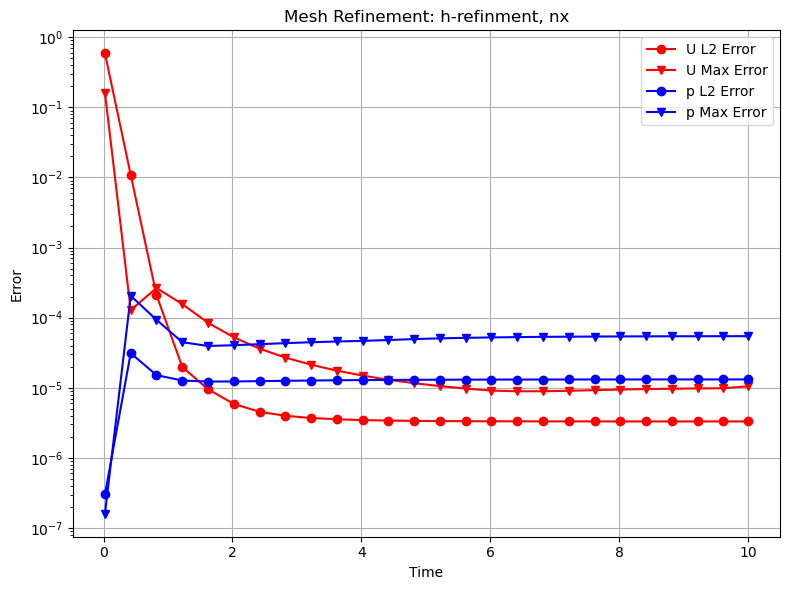

In [8]:
# *** LOOP OVER TIME TO SOLVE *** #

time = []
L2errU = []
maxErrU = []
L2errp = []
maxErrp = []

for i in range(num_steps):
    # Update current time step
    t += dt

    # Step 1: Tentative veolcity step
    with b1.localForm() as loc_1:
        loc_1.set(0)
    assemble_vector(b1, L1) # rhs of eq 39 is stored in b1 as a vector
    apply_lifting(b1, [a1], [bcu]) # apply BC to the coefficient matrix
    b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) # sync for parallel processing
    set_bc(b1, bcu) # set BC on the rhs
    solver1.solve(b1, u_.x.petsc_vec) # solve A1 * u* = b1 based on set schemes
    u_.x.scatter_forward() # sync for parallel processing

    # Step 2: Pressure corrrection step
    with b2.localForm() as loc_2:
        loc_2.set(0)
    assemble_vector(b2, L2) # rhs of eq. 40 is stored in b2
    apply_lifting(b2, [a2], [bcp]) # apply BC to the coefficient matrix
    b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) # sync for parallel processing
    set_bc(b2, bcp) # set the BC
    solver2.solve(b2, p_.x.petsc_vec) # solve A2*p = b2 based on set schemes
    p_.x.scatter_forward() # sync for parallel processing

    # Step 3: Velocity correction step
    with b3.localForm() as loc_3:
        loc_3.set(0)
    assemble_vector(b3, L3) # rhs of eq. 42 stored in b3
    b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE) # sync for parallel processing
    solver3.solve(b3, u_.x.petsc_vec) # solve A3 * u = b3 based on set schemes
    u_.x.scatter_forward() # sync for parallel processing
    # Update variable with solution form this time step
    u_n.x.array[:] = u_.x.array[:]
    p_n.x.array[:] = p_.x.array[:]

    # Write solutions to file
    vtx_u.write(t)
    vtx_p.write(t)

    # Compute error at current time-step
    error_L2 = np.sqrt(mesh.comm.allreduce(assemble_scalar(L2_error), op=MPI.SUM))
    error_max = mesh.comm.allreduce(np.max(u_.x.petsc_vec.array - u_ex.x.petsc_vec.array), op=MPI.MAX)

    error_L2p = np.sqrt(mesh.comm.allreduce(assemble_scalar(L2_error_p), op=MPI.SUM))
    error_maxp = mesh.comm.allreduce(np.max(p_.x.petsc_vec.array - p_ex.x.petsc_vec.array), op=MPI.MAX)
    # Print error only every 20th step and at the last step

    if (i % 20 == 0) or (i == num_steps - 1):
        time.append(t)
        L2errU.append(error_L2)
        maxErrU.append(error_max)
        L2errp.append(error_L2p)
        maxErrp.append(error_maxp)
        #print(f"Time {t:.2f}, L2-error {error_L2:.2e}, Max error {error_max:.2e}")
        print(f"Time {t:.2f}, U L2-error {error_L2:.2e}, Max U error {error_max:.2e}\n \t \tp L2-error {error_L2p:.2e}, Max p error {error_maxp:.2e}")

# Close xmdf files
vtx_u.close()
vtx_p.close()
# detroy the solvers and the vectors
b1.destroy()
b2.destroy()
b3.destroy()
solver1.destroy()
solver2.destroy()
solver3.destroy()

%matplotlib inline
plt.figure(figsize=(8, 6))
plt.semilogy(time, L2errU, 'ro-', time, maxErrU, 'rv-',time, L2errp, 'bo-', time, maxErrp, 'bv-')
#plt.semilogx(q_loop, all_w_analytic, 'b--', label="Analytical w")
plt.xlabel("Time")
plt.ylabel("Error")
plt.title("Mesh Refinement: h-refinment, nx")
plt.legend(("U L2 Error", "U Max Error", "p L2 Error", "p Max Error"))
plt.grid(True)
plt.tight_layout()

From the above plot, we see that the error for both pressure and velocity converge, meaning that the steady state solution has been found. Additionally, the maximum error is less than $10^{-4}$, so the results of the FEniCSx solver are verified.